In [26]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import time
from sklearn.model_selection import train_test_split

In [27]:
"""Subtractive Clustering Algorithm
"""

def SubstractiveClustering(data, Ra, Rb, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

In [28]:
"""
Sugeno type FIS.
"""
def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        self.solutions=[]
    
    def genfis(self, data, labels, cluster_center):
        start_time = time.time()
        n_clusters = len(cluster_center)
        cluster_center = cluster_center[:,:-1]
        varInput = data[:,:-1]
        maxValue = np.max(varInput, axis=0)
        minValue = np.min(varInput, axis=0)
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        varInput = data[:,:-1] 
        varOuput = data[:,-1]
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs]) 
        f = [np.prod(gaussmf(varInput,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        varInput = np.c_[varInput, np.ones(len(varInput))]
        n_vars = varInput.shape[1]
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = varInput[:, orden]
        A = acti*inp/sumMu
        solutions, residuals, rank, s = np.linalg.lstsq(A,varOuput,rcond=None)
        self.solutions = solutions
        return 0
    
    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        P = np.c_[data, np.ones(len(data))]
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        return np.sum(acti*inp*coef/sumMu,axis=1)

    def viewInputs(self):
        for input in self.inputs:
            input.view()

In [29]:
#funcion de automatizacion
def automation(data_x,data_y,test_size,Ra,Rb): #Parametros division de datos data,test_size; clustering substractivo Ra,Rb; 
    '''                                 DIVISION DE LOS DATOS                              '''
    vda_entrenamiento, vda_esperados, tiempo_entrenamiento, tiempo_prueba = train_test_split(data_y, data_x, test_size=test_size, random_state=10) #random_state modifica la distancia entre los puntos que tomo para test.
    dataTrain = np.hstack((tiempo_entrenamiento,vda_entrenamiento)) # datos de entrenamiento
    dataTest = np.hstack((tiempo_prueba,vda_esperados)) # datos testing
    '''                                 CLUSTERING SUSTRACTIVO                             '''
    labels,centers = SubstractiveClustering(dataTrain,Ra,Rb) 
    plt.figure()
    plt.title(label='Clustering sustractivo para Ra={}'.format(Ra))
    plt.scatter(dataTrain[:,0],dataTrain[:,1],c=labels, s=7,label='datos train')
    plt.scatter(centers[:,0],centers[:,1], marker='X',s=20,c="black", label='clusters')
    plt.legend()
    plt.show()
    '''                                 SUGENO                                             '''
    fis2 = fis() # genero la clase fis, mejor llamado modelo de Sugeno
    fis2.genfis(dataTrain,labels,centers)
    fis2.viewInputs()

    '''                                 MODULO DE GRAFICO DE FUNCION SOLUCION DE SUGENO CON DATOS DE ENTRENAMIENTO                          '''
    
    maxValue =int(np.max(data_x))
    arreglo = np.linspace(1,maxValue,maxValue)                            #Generamos un arreglo con numeros del 1 al 350 para el eje x a graficar
    arreglo = arreglo.reshape(-1,1)
    coordenadas_y= fis2.evalfis(arreglo)                          #Generamos los valores del eje y a partir de la funcion solucion obtenida
   

    '''                                 MODULO DE VALIDACION Y CALCULO DE ERRORES                         datos_obtenidos '''
    errores = []
    resultado_obtenido = fis2.evalfis((tiempo_prueba))

    for i in range(len(resultado_obtenido)):
        resultado = resultado_obtenido[i] - vda_esperados[i]
        print(f" error en ierror{i}, error:  {resultado} , resultado_obtenido = {resultado_obtenido[i]}, resultado_esperado = {vda_esperados[i]}")
        errores.append(resultado)

    errores = np.sqrt(np.square(errores))
    promedio_error = np.mean(errores)

    plt.figure()
    plt.scatter(tiempo_entrenamiento,vda_entrenamiento, s=7, label='datos train')
    plt.scatter(tiempo_prueba,vda_esperados,color='red',s=7, label='datos test')
    plt.plot(arreglo,coordenadas_y,linestyle='-',color='yellow', label='solucion sugeno')
    plt.xlabel('Tiempo')

    plt.legend()

    plt.title('Gráfico de Dispersión de Presión Arterial vs. Tiempo para Ra={}'.format(Ra))
    plt.grid(True)
    plt.show()
    
    print(f"Error promedio: {promedio_error}")
    return promedio_error*100/len(data_x)


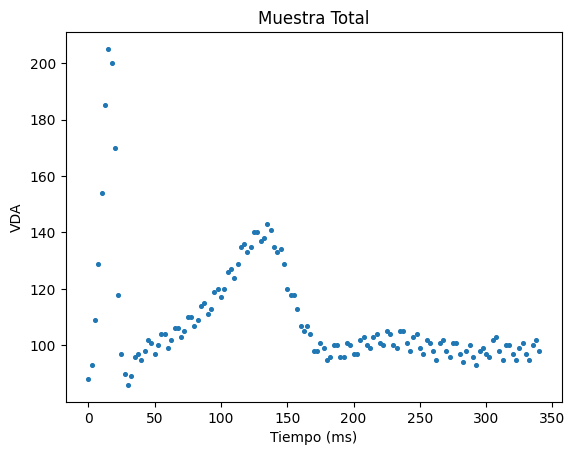

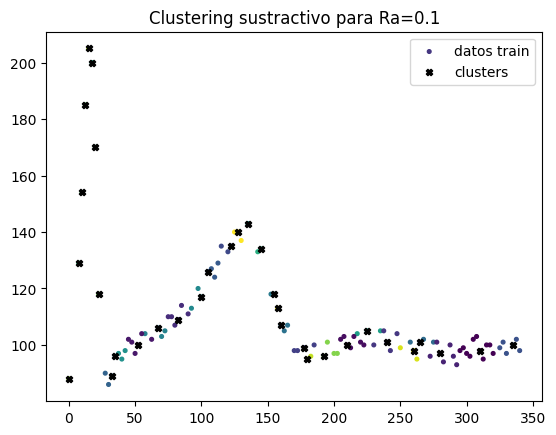

 error en ierror0, error:  [-5.73338789] , resultado_obtenido = 94.26661211108149, resultado_esperado = [100.]
 error en ierror1, error:  [6.73396935] , resultado_obtenido = 101.73396934830089, resultado_esperado = [95.]
 error en ierror2, error:  [2.99706507] , resultado_obtenido = 122.99706507190422, resultado_esperado = [120.]
 error en ierror3, error:  [-2.97674163] , resultado_obtenido = 99.02325836730597, resultado_esperado = [102.]
 error en ierror4, error:  [3.02989291] , resultado_obtenido = 98.02989291007543, resultado_esperado = [95.]
 error en ierror5, error:  [-1.8455993] , resultado_obtenido = 99.15440069747274, resultado_esperado = [101.]
 error en ierror6, error:  [2.77350997] , resultado_obtenido = 99.77350997096801, resultado_esperado = [97.]
 error en ierror7, error:  [-2.46643481] , resultado_obtenido = 126.5335651915957, resultado_esperado = [129.]
 error en ierror8, error:  [-4.68389454] , resultado_obtenido = 95.31610545984586, resultado_esperado = [100.]
 error 

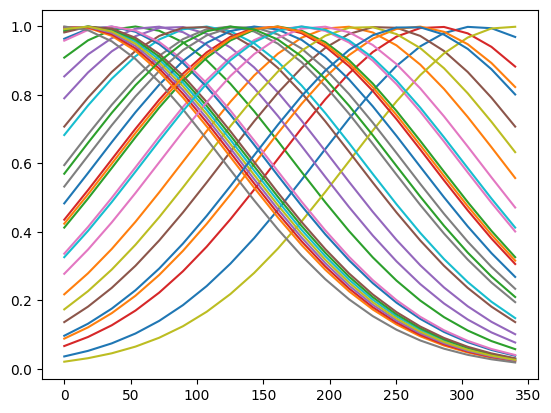

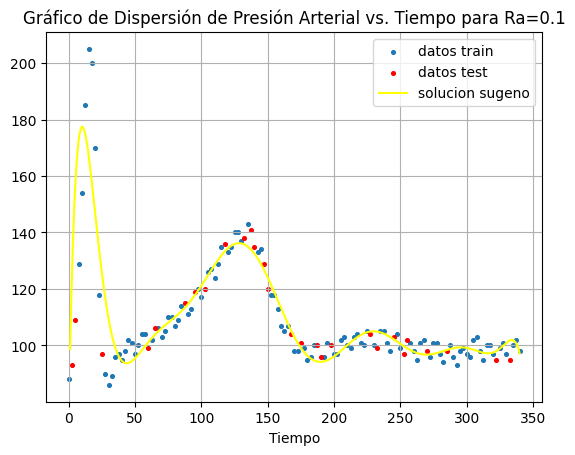

Error promedio: 6.524369949571597
[4.762313831804086]


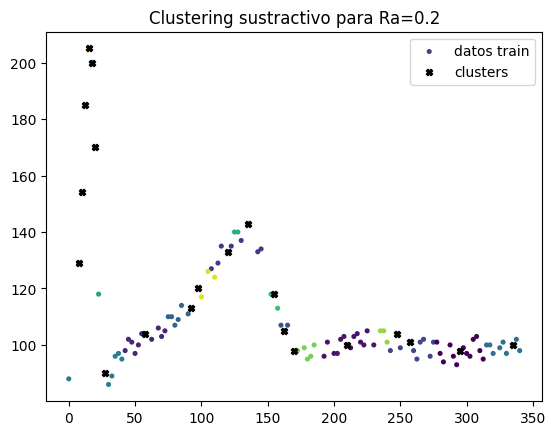

 error en ierror0, error:  [-6.07885742] , resultado_obtenido = 93.921142578125, resultado_esperado = [100.]
 error en ierror1, error:  [7.37548828] , resultado_obtenido = 102.37548828125, resultado_esperado = [95.]
 error en ierror2, error:  [2.78759766] , resultado_obtenido = 122.78759765625, resultado_esperado = [120.]
 error en ierror3, error:  [-3.25177002] , resultado_obtenido = 98.74822998046875, resultado_esperado = [102.]
 error en ierror4, error:  [2.89447021] , resultado_obtenido = 97.89447021484375, resultado_esperado = [95.]
 error en ierror5, error:  [-2.0213623] , resultado_obtenido = 98.9786376953125, resultado_esperado = [101.]
 error en ierror6, error:  [2.54193115] , resultado_obtenido = 99.54193115234375, resultado_esperado = [97.]
 error en ierror7, error:  [-2.09448242] , resultado_obtenido = 126.905517578125, resultado_esperado = [129.]
 error en ierror8, error:  [-4.9230957] , resultado_obtenido = 95.076904296875, resultado_esperado = [100.]
 error en ierror9, e

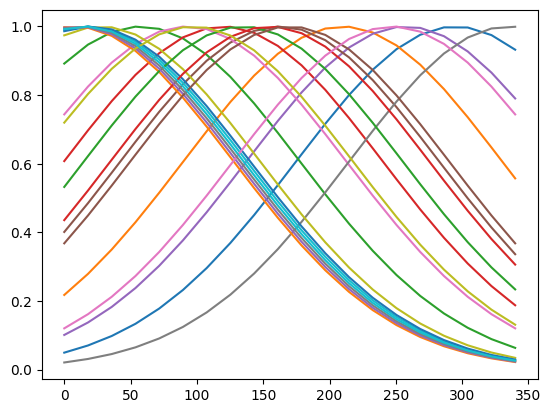

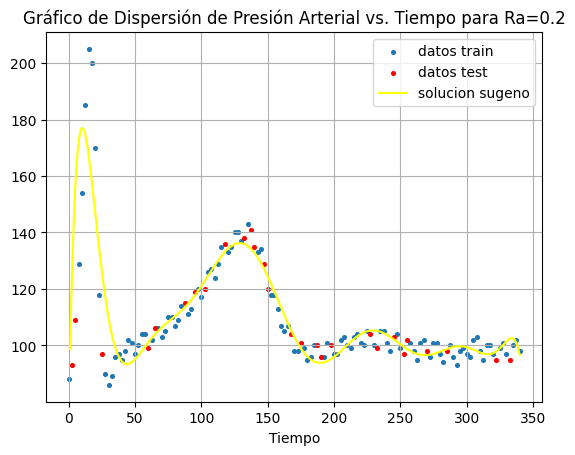

Error promedio: 6.566311972481864
[4.762313831804086, 4.7929284470670535]


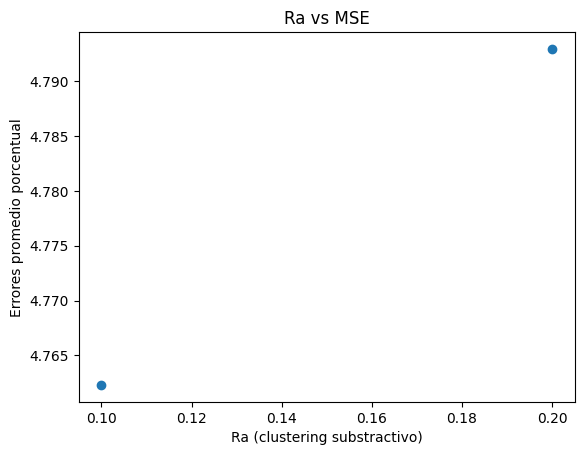

In [30]:
'''                                 MODULO DE LECTURA DE ARCHIVO                                      '''

from sklearn.model_selection import train_test_split
import numpy as np

# Cargar los datos desde el archivo de texto
vda = np.loadtxt("samplesVDA2.txt")
cant_datos = vda.shape[0]
medidas_x_segundo = 400 
npyarray=np.array
tiempo = np.arange(0,cant_datos/400,1/medidas_x_segundo)
tiempo = tiempo*1000

data_y = vda.reshape(-1,1) 
data_x = tiempo.reshape(-1,1)

dataGral=np.hstack((data_y,data_x))

#Graficamos los datos totales
plt.scatter(data_x, data_y,s=7)
plt.xlabel('Tiempo (ms)')
plt.ylabel('VDA')
plt.title('Muestra Total')
plt.show()

errores_totales=[]
vectorRa=[]
Ra=0
for i in range (0,2):
    Ra+=0.1
    vectorRa.append(Ra)
    errores_totales.append(automation(data_x,data_y,0.2,Ra,0))
    print(errores_totales)

plt.figure()
plt.scatter(vectorRa, errores_totales)
plt.ylabel('Errores promedio porcentual')
plt.xlabel('Ra (clustering substractivo)')
plt.title('Ra vs MSE')
plt.show()

